# Preparation

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [33]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.model_selection import train_test_split

from torch.utils.data import TensorDataset, DataLoader
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch.utils.data.sampler import WeightedRandomSampler
from torch.optim import lr_scheduler

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score

from fetchData import fetchdata 

In [9]:
if torch.cuda.is_available():       
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

No GPU available, using the CPU instead.


In [10]:
pheme_w2v = pd.read_csv('./data/_PHEME_text_AVGw2v.csv').drop(['token'],axis=1)
pheme_y = pd.read_csv('./data/_PHEME_target.csv').target
pheme_sparse = pd.read_csv('./data/_PHEME_sparse.csv')
pheme_event = pd.read_csv('./data/_PHEME_text.csv').Event

ext_w2v = pd.read_csv('./data/_PHEMEext_text_AVGw2v.csv').drop(['token'],axis=1)
ext_y = pd.read_csv('./data/_PHEMEext_text.csv').target
ext_sparse = pd.read_csv('./data/_PHEMEext_sparse.csv')
ext_event = pd.read_csv('./data/_PHEMEext_text.csv').Event

rhi = pd.read_csv('./data/_RHI_text_AVGw2v.csv').drop(['token'],axis=1)
rhi_y = pd.read_csv('./data/_RHI_target.csv')

pheme_bert = fetchdata('pheme','bert')
ext_bert = fetchdata('ext','bert')
rhi_bert = fetchdata('rhi','bert')

In [11]:
pheme_sparse.verified = pheme_sparse.verified.replace({True: 1, False: 0}) 
ext_sparse.verified = ext_sparse.verified.replace({True: 1, False: 0}) 
pheme_sparse.has_question = pheme_sparse.has_question.replace({True: 1, False: 0}) 
ext_sparse.has_question = ext_sparse.has_question.replace({True: 1, False: 0}) 
pheme_sparse.has_exclaim = pheme_sparse.has_exclaim.replace({True: 1, False: 0}) 
ext_sparse.has_exclaim = ext_sparse.has_exclaim.replace({True: 1, False: 0}) 
pheme_sparse.has_period = pheme_sparse.has_period.replace({True: 1, False: 0}) 
ext_sparse.has_period = ext_sparse.has_period.replace({True: 1, False: 0}) 

In [112]:
def train(model, num_epochs, criterion, optimizer, train_loader, test_loader=None, patience=5, PATH='./state_dict_model.pt'):
    train_loss = []
    patience_count=0
    train_accuracy = []
    prev_loss = 10
    best_loss = 10.0
    val_corrects_list = []
    val_loss_list = []
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        # print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        # print('-' * 10)
        running_corrects = 0.0
        running_loss = 0.0
        model.train()  # Set model to training mode
        for i, data in enumerate(train_loader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs, labels = inputs.float(), labels.float()

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)

            #  _, predictions = torch.max(outputs.data, 1) won’t work if your output only contains a single output unit.
            # _, preds = torch.max(outputs, 1)
            # print(outputs.flatten().size())
            preds = outputs > 0.0

            loss = criterion(outputs, labels.unsqueeze(1))
            loss.backward()
            optimizer.step()

            # step function
            scheduler.step() 

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / train_size
        # print(running_loss)
        # print(train_size)
        epoch_acc = running_corrects.double() / train_size
        train_loss.append(epoch_loss)
        train_accuracy.append(epoch_acc)
        if (epoch%2==0):
            print('Epoch {}/{}\tTrain) Acc: {:.4f}, Loss: {:.4f}'.format(epoch, num_epochs - 1,epoch_acc, epoch_loss))
        if (test_loader != None):
            model.eval()
            with torch.no_grad():
                val_loss = 0.0
                val_corrects = 0
                val_preds_list = []
                val_label_list = []
                for j, val in enumerate(test_loader, 0):
                    val_x, val_label = val
                    val_x, val_label = val_x.float(), val_label.float()
                    val_outputs = model(val_x)
                    # _, val_preds = torch.max(val_ou ntputs, 1)
                    val_preds = val_outputs > 0.0
                    val_preds_list.append(val_preds)
                    val_label_list.append(val_label)
                    v_loss = criterion(val_outputs, val_label.unsqueeze(1))
                    val_loss += (v_loss.item() * val_x.size(0))
                    val_corrects += torch.sum(val_preds == val_label.data).double()
                if (epoch%2==0):
                    val_preds_list = torch.cat(val_preds_list, 0)
                    val_label_list = torch.cat(val_label_list, 0)
                    # print("\t\tValidation) Acc: {:.4f} Loss:{:.4f} F1 score: {:4f}".format(val_corrects/test_size, val_loss/test_size, f1_score(val_label_list,val_preds_list,average='macro')))
                    print("\t\tValidation) Acc: {:.4f} Loss:{:.4f}".format(val_corrects/test_size, val_loss/test_size))
                val_corrects_list.append(val_corrects/test_size)
                val_loss_list.append(val_loss/test_size)

        if epoch_loss < best_loss:
            # print("prev_loss: {:.5f}".format(prev_loss))
            # print("loss: {:.5f}".format(loss))
            print("\t\tSaving the best model w/ loss {:.4f}".format(epoch_loss))
            torch.save(model.state_dict(),PATH)
            best_loss = epoch_loss
            patienc=0
        elif best_loss <= epoch_loss:
            patience_count+=1
        if patience_count >= patience:
            print("Finishing the Model: Loss is not decreasing...")
            print(train_loss[-6:-1])
            return train_accuracy, train_loss
    return train_accuracy, train_loss

# Sparse-MLP

In [96]:
PATH = './Model/MLP_W2V_to_Sigmoid_ord.pt'
# bn_state_dict = torch.load('./BERT_raw_to_fine_tune_ord.pt')
# bert_classifier.load_state_dict(bn_state_dict)
model.load_state_dict(torch.load(PATH))

NameError: name 'model' is not defined

In [63]:
train_inputs = torch.tensor(pheme_sparse.values).float()
val_inputs = torch.tensor(ext_sparse.values).float()

# Convert other data types to torch.Tensor
train_labels = torch.tensor(pheme_y.values).float()
val_labels = torch.tensor(ext_y.values).float()

# For fine-64 BERT, the authors recommend a batch size of 16 or 32.
batch_size = 32

# Initialize WeightedRandomSampler to deal with the unbalanced dataset
counts = np.bincount(pheme_y.values)
labels_weights = 1. / counts
weights = labels_weights[pheme_y.values]
train_sampler = WeightedRandomSampler(weights, len(weights))

# Create the DataLoader for our training set
train_data = TensorDataset(train_inputs, train_labels)
# train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set
val_data = TensorDataset(val_inputs, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

In [12]:
class model1(nn.Module):
    def __init__(self):
        super(model1, self).__init__()
        self.fc1 = nn.Linear(in_features=27, out_features=8, bias=True)
        self.fc2 = nn.Linear(in_features=8, out_features=4)
        self.output = nn.Linear(in_features=4, out_features=1)
        self.drop2 = nn.Dropout(0.2)
        # self.softmax = nn.Linear(dim=1)

    def forward(self, x):
        x = self.drop2(F.relu(self.fc1(x)))
        x = F.relu(self.fc2(x))
        x = self.output(x)
        return x


def train(train_loader, val_dataloader=None, epochs=100, verbose=True, evaluation=False):
    prev_loss = 10
    PATH = "./state_dict_model_ai_task1.pt"

    print("Start training...\n")
    val_loss_list = []
    val_acc_list = []
    train_loss = []         # training 과정에서 각 epoch마다의 평균 loss를 저장
    train_accuracy = []     # training 과정에서 각 epoch마다의 평균 acc를 저장
    train_correct = []
    print(f"{'Epoch':^7} | {'Batch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val Acc':^9}")


    num_step = len(train_loader)

    for epoch in range(epochs):
        epoch_count = 0
        total_loss, batch_loss, batch_counts = 0, 0, 0
        model.train()
        # print('Epoch {}/{}'.format(epoch, epochs - 1))
        # print('-' * 10)
        epoch_corrects = 0  # 한 epoch마다 각 batch의 데이터를 저장
        epoch_loss = 0
        epoch_accuracy = []
        temp=[]

        for i, data in enumerate(train_loader):
            batch_count = 0

            train, label = data
            train, label = train.float(), label.float()

            output = model.forward(train)

            # _, preds = torch.max(output, 1)
            y2 = torch.zeros(len(output))
            y2[output.flatten()>=0.5] = 1
            # print(preds)
            # print(label)
            acc = (y2.int() == label).cpu().numpy().mean() * 100
            batch_correct = (y2.int() == label).cpu().numpy().sum()
            temp.append(batch_correct)

            # loss = criterion(output.float(), label.unsqueeze(1).float())
            loss = criterion(output.float(), label.float())
            batch_loss += loss.item()
            # total_loss += loss.item()

            loss.backward()

            optimizer.step()
            optimizer.zero_grad()
            # print(loss.item())
            # print(train.size(0))
            epoch_loss += loss.item()*train.size(0)
            epoch_accuracy.append(acc)
            # print(torch.sum(preds == label))
            # epoch_corrects.append(torch.sum(preds == label))

            # Clip the norm of the gradients to 1.0 to prevent "exploding gradients"
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            batch_count += len(label)
        epoch_corrects += batch_correct
        epoch_loss = epoch_loss/len(train_loader.sampler)
        epoch_accruacy = epoch_corrects / batch_count
        # avg_train_loss = total_loss / len(train_dataloader)
        # print(temp)
        # print(np.sum(temp))

        # train_loss.append(epoch_corrects)
        train_accuracy.append(epoch_accruacy)
        train_correct.append(epoch_corrects)
        train_loss.append(epoch_loss)

        if epoch % 10 == 0 and verbose == True:
            print("Epoch: {}, Loss: {:.5f}".format(epoch + 1, loss.item()))
            print('Train) Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, np.mean(epoch_accuracy)))

        if epoch % 5 == 0 and loss < prev_loss:
            # print("prev_loss: {:.5f}".format(prev_loss))
            # print("loss: {:.5f}".format(loss))
            print("Saving the best model")
            torch.save(model.state_dict(), PATH)
            prev_loss = loss.item()
        

        # =======================================
        #               Evaluation
        # =======================================
        if evaluation == True:
            # After the completion of each training epoch, measure the model's performance
            # on our validation set.

            val_correct, val_acc, val_loss = evaluate(val_dataloader)
            val_loss_list.append(val_loss)
            val_acc_list.append(val_acc)

            # Print performance over the entire training data
            # print(val_loss_list)
            # print(f"{'Epoch':^7} | {'Batch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val Acc':^9}")
            if epoch % 10 == 0 and verbose == True:
                print(
                    f"{epoch + 1:^7} | {'-':^7} | {epoch_loss:^12.6f} | {val_loss:^10.6f} | {val_acc:^9.2f}")
                print("-"*70)
            if epoch % 5 == 0 and loss < prev_loss:
                print("Saving the best model")
                torch.save(model.state_dict(), PATH)
                prev_loss = loss.item()
        else:
            if epoch % 10 == 0 and verbose == True:
                print(
                    f"{epoch + 1:^7} | {'-':^7} | {epoch_loss:^12.6f}")
                print("-"*70)
            if epoch % 5 == 0 and loss < prev_loss:
                print("Saving the best model")
                torch.save(model.state_dict(), PATH)
                prev_loss = loss.item()
            
    # torch.save(model.state_dict(),PATH)

    fig, ax = plt.subplots(3, 1, figsize=(12,8))
    ax[0].plot(train_loss)
    ax[0].set_ylabel('Loss')
    ax[0].set_title('Training Loss')

    ax[1].plot(train_accuracy)
    ax[1].set_ylabel('Classification Accuracy')
    ax[1].set_title('Training Accuracy')

    ax[2].plot(val_acc_list)
    ax[2].set_ylabel('Classification Accuracy')
    ax[2].set_title('Validation Accuracy')

    plt.tight_layout()
    plt.show()

    print("Accuracy: {}, Loss: {:.5f}".format(train_accuracy[-1], loss.item()))
    # return train_loss, train_accuracy, loss


def evaluate(val_dataloader, verbose=True):
    correct = 0
    total = 0
    outputs_list = []

    val_loss = []
    val_corrects = 0
    val_acc = []
    valid_loss = 0.0

    batch_count = 0

    model.eval()
    with torch.no_grad():
        for j, val in enumerate(val_dataloader):
            inputs, label = val
            inputs, label = inputs.float(), label.float()
            output = model(inputs)
            # _, preds = torch.max(output, 1)
            
            
            loss = criterion(output, label.unsqueeze(1))

            y2 = torch.zeros(len(output))
            y2[output.flatten()>=0.5] = 1

            acc = (y2.int() == label.int()).cpu().numpy().mean() * 100
            correct = (y2.int() == label.int()).cpu().numpy().sum()
            # print(correct)

            # print((preds == label).cpu().numpy().sum())

            val_loss.append(loss.item())
            val_corrects += correct
            val_acc.append(acc)
            batch_count += len(inputs)
            valid_loss += loss.item()*inputs.size(0)

            # print(j,len(inputs),correct)


    total_correct = np.sum(val_corrects)
    # total_loss = np.mean(val_loss)
    # print("val_corrects:", val_corrects)
    # print("batch count:", batch_count)
    # print("batch valid_loss:", valid_loss)
    
    total_acc = val_corrects/batch_count
    # print("total_acc:", total_acc)
    # print("Validation) Acc: {:.4f} ".format(total_acc))
    valid_loss = valid_loss/len(val_dataloader.sampler)
    # print("batch valid_loss 2:", valid_loss)


    return val_corrects, total_acc, valid_loss


In [355]:
model = model1()
model

model1(
  (fc1): Linear(in_features=27, out_features=8, bias=True)
  (fc2): Linear(in_features=8, out_features=4, bias=True)
  (output): Linear(in_features=4, out_features=1, bias=True)
)

In [13]:
criterion = nn.BCEWithLogitsLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
optimizer = optim.SGD(model.parameters(), lr=1e-05 , momentum=0.9)

train(train_dataloader, val_dataloader=val_dataloader, epochs=100, evaluation=True)

NameError: name 'train_dataloader' is not defined

### Molecular Activity Data

In [33]:
from sklearn.datasets import load_breast_cancer
data = load_breast_cancer()
X_train = pd.DataFrame(data['data'])
y_train = pd.DataFrame(data['target'])

# train_test_split(pd.concat([X_train]), random_state=42)


In [34]:
X_train.shape

(569, 30)

In [38]:
from torch.utils.data.sampler import WeightedRandomSampler

train_inputs = torch.tensor(X_train.values)
# val_inputs = torch.tensor(X_test.values)

# Convert other data types to torch.Tensor
train_labels = torch.tensor(y_train.values)
# val_labels = torch.tensor(y_test.values)

# For fine-tuning BERT, the authors recommend a batch size of 16 or 32.
batch_size = 32

# Initialize WeightedRandomSampler to deal with the unbalanced dataset
# counts = np.bincount(y_train.values)
# print(count)
# labels_weights = 1. / counts
# weights = labels_weights[pheme_y.values]
# train_sampler = WeightedRandomSampler(weights, len(weights))


# Create the DataLoader for our training set
train_data = TensorDataset(train_inputs, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# # Create the DataLoader for our validation set
val_data = TensorDataset(val_inputs, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

In [39]:
model = model1()
model

model1(
  (fc1): Linear(in_features=30, out_features=8, bias=True)
  (fc2): Linear(in_features=8, out_features=4, bias=True)
  (output): Linear(in_features=4, out_features=1, bias=True)
  (drop2): Dropout(p=0.2, inplace=False)
)

Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc 
Epoch: 1, Loss: 0.66275
Train) Loss: 18.7595 Acc: 41.8715
Saving the best model
   1    |    -    |  18.759461  
----------------------------------------------------------------------
Epoch: 11, Loss: 0.67435
Train) Loss: 0.6604 Acc: 62.7083
  11    |    -    |   0.660370  
----------------------------------------------------------------------
Saving the best model
Epoch: 21, Loss: 0.65412
Train) Loss: 0.6610 Acc: 42.4514
  21    |    -    |   0.660954  
----------------------------------------------------------------------
Epoch: 31, Loss: 0.63316
Train) Loss: 0.6605 Acc: 62.8056
  31    |    -    |   0.660469  
----------------------------------------------------------------------
Epoch: 41, Loss: 0.69519
Train) Loss: 0.6605 Acc: 62.6597
  41    |    -    |   0.660493  
----------------------------------------------------------------------
Epoch: 51, Loss: 0.65396
Train) Loss: 0.6606 Acc: 62.7569
  51    |  

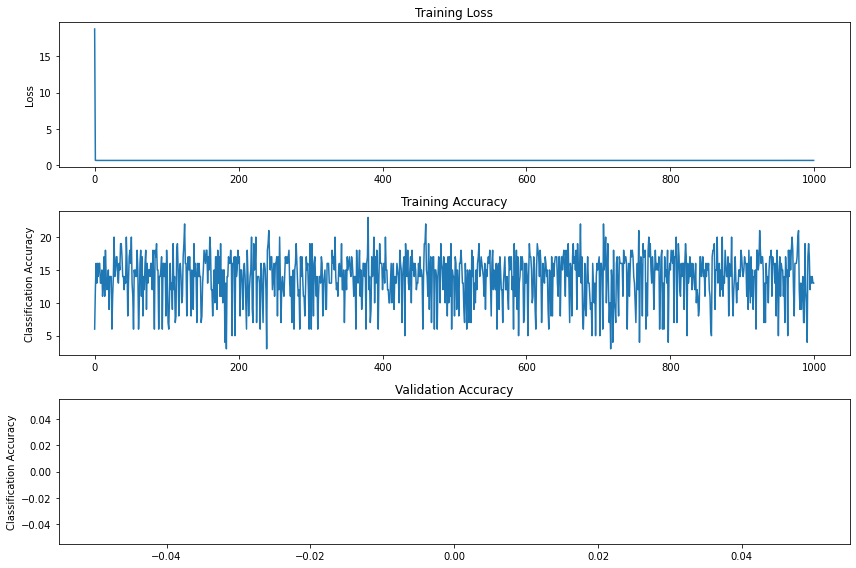

Accuracy: 13.0, Loss: 0.71637


In [40]:
criterion = nn.BCEWithLogitsLoss()
# criterion = nn.BCELoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
optimizer = optim.SGD(model.parameters(), lr=0.03, momentum=0.9)

# train_loss, train_accuracy, loss = 
train(train_dataloader, val_dataloader=None, epochs=1000, evaluation=True)

In [ ]:
torch.save(model.state_dict(), './MLP_Sparse_CLF_ord.pt')

# Sparse-MLP - again

In [70]:
tensor_x1 = torch.Tensor(pheme_sparse.values).unsqueeze(1)
tensor_y1 = torch.Tensor(pheme_y.values).unsqueeze(1)
train_dataset = TensorDataset(tensor_x1,tensor_y1)

tensor_x2 = torch.Tensor(ext_sparse.values).unsqueeze(1)
tensor_y2 = torch.Tensor(ext_y.values).unsqueeze(1)
test_dataset = TensorDataset(tensor_x2,tensor_y2)

# For fine-tuning BERT, the authors recommend a batch size of 16 or 32.
batch_size = 16

# Initialize WeightedRandomSampler to deal with the unbalanced dataset
counts = np.bincount(pheme_y.values)
labels_weights = 1. / counts
weights = labels_weights[pheme_y.values]
train_sampler = WeightedRandomSampler(weights, len(weights))
test_sampler = SequentialSampler(tensor_x2)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler, num_workers=2)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

train_size = int(tensor_y1.size(0))
test_size = int(tensor_y2.size(0))


In [65]:
print(tensor_x1.shape)
print(tensor_y1.shape)
print(train_size)
print(test_size)

torch.Size([5802, 1, 27])
torch.Size([5802, 1])
5802
485


In [66]:
class FC_net(nn.Module):
    def __init__(self):
        super(FC_net, self).__init__() # 1*20
        self.fc1 = nn.Linear(27, 12, bias=True) # 420
        self.fc2 = nn.Linear(12, 8, bias=True)
        self.fc3 = nn.Linear(8, 1)

        self.drop_3 = nn.Dropout(0.3)
        self.drop_4 = nn.Dropout(0.4)
        self.drop_2 = nn.Dropout(0.2)

    def forward(self, x):
        x = self.drop_2(F.elu(self.fc1(x)))
        x = F.elu(self.fc2(x))
        x = self.fc3(x)
        return x

In [67]:
import torch.optim as optim

model_sparse = FC_net()
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(model_sparse.parameters(), lr=0.001, momentum=0.9)
# optimizer = optim.Adam(model_sparse.parameters(), lr=1e-04)
scheduler = lr_scheduler.ExponentialLR(optimizer, gamma= 0.99)  

In [68]:
train_loss = []
train_accuracy = []

prev_loss = 10
PATH = "./Model/state_dict_sparse_model.pt"

In [69]:
train(model=model_sparse, num_epochs=100, criterion=criterion, optimizer=optimizer, train_loader=train_dataloader, test_loader=test_dataloader, PATH=PATH)

Epoch 0/99	Train) Acc: 16.2203, Loss: 14.0647
		Validation) Acc: 24.3464 Loss:0.6355
		Saving the best model w/ loss 0.9392
Epoch 2/99	Train) Acc: 15.9945, Loss: 0.9378
		Validation) Acc: 24.3464 Loss:0.6464
		Saving the best model w/ loss 0.9378
Epoch 4/99	Train) Acc: 16.1610, Loss: 0.8959
		Validation) Acc: 24.3464 Loss:0.6467
		Saving the best model w/ loss 0.8959
Epoch 6/99	Train) Acc: 16.2182, Loss: 0.9077
		Validation) Acc: 24.3464 Loss:0.6467
Epoch 8/99	Train) Acc: 15.5688, Loss: 0.9529
		Validation) Acc: 24.3464 Loss:0.6467
Epoch 10/99	Train) Acc: 16.0855, Loss: 0.9394
		Validation) Acc: 24.3464 Loss:0.6467
Epoch 12/99	Train) Acc: 15.6701, Loss: 0.9558
		Validation) Acc: 24.3464 Loss:0.6467
Epoch 14/99	Train) Acc: 16.3271, Loss: 0.9101
		Validation) Acc: 24.3464 Loss:0.6467
Epoch 16/99	Train) Acc: 15.9697, Loss: 0.9272
		Validation) Acc: 24.3464 Loss:0.6467
Epoch 18/99	Train) Acc: 16.0972, Loss: 0.9159
		Validation) Acc: 24.3464 Loss:0.6467
Epoch 20/99	Train) Acc: 16.0028, Loss

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/Users/june/miniconda3/envs/rosetta/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3437, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-69-b9c3f55d8c14>", line 1, in <module>
    train(model=model_sparse, num_epochs=100, criterion=criterion, optimizer=optimizer, train_loader=train_dataloader, test_loader=test_dataloader, PATH=PATH)
  File "<ipython-input-12-cc46966bd43e>", line 14, in train
    for i, data in enumerate(train_loader, 0):
  File "/Users/june/miniconda3/envs/rosetta/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 517, in __next__
    data = self._next_data()
  File "/Users/june/miniconda3/envs/rosetta/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1182, in _next_data
    idx, data = self._get_data()
  File "/Users/june/miniconda3/envs/rosetta/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1148, in _get_data
    s

TypeError: object of type 'NoneType' has no len()

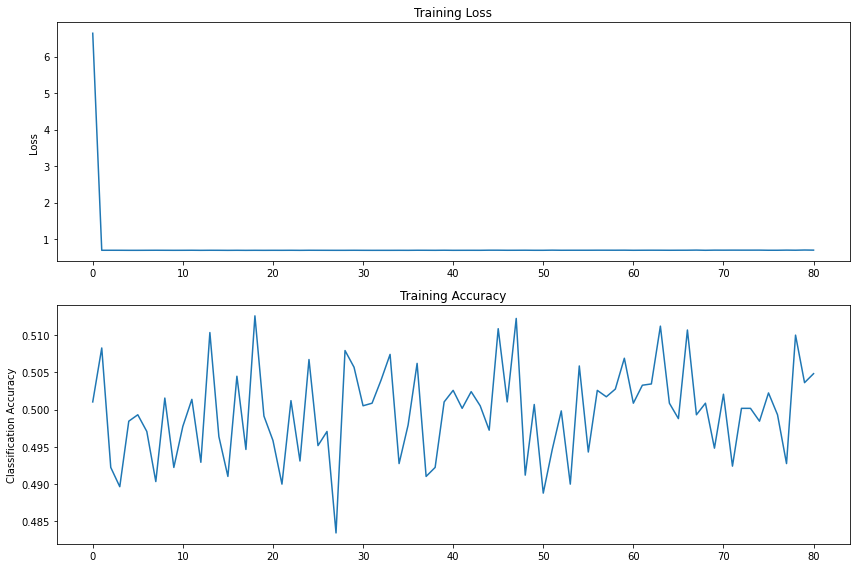

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(12,8))
ax[0].plot(train_loss[:])
ax[0].set_ylabel('Loss')
ax[0].set_title('Training Loss')

ax[1].plot(train_accuracy[:])
ax[1].set_ylabel('Classification Accuracy')
ax[1].set_title('Training Accuracy')

plt.tight_layout()
plt.show()

# W2V-MLP

In [97]:
tensor_x1 = torch.Tensor(pheme_w2v.values).unsqueeze(1)
tensor_y1 = torch.Tensor(pheme_y.values).unsqueeze(1)
train_dataset = TensorDataset(tensor_x1,tensor_y1)

tensor_x2 = torch.Tensor(ext_w2v.values).unsqueeze(1)
tensor_y2 = torch.Tensor(ext_y.values).unsqueeze(1)
test_dataset = TensorDataset(tensor_x2,tensor_y2)

In [98]:
# Initialize WeightedRandomSampler to deal with the unbalanced dataset
counts = np.bincount(pheme_y.values)
labels_weights = 1. / counts
weights = labels_weights[pheme_y.values]
train_sampler = WeightedRandomSampler(weights, len(weights))
test_sampler = SequentialSampler(tensor_x2)

batch_size = 16

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler, num_workers=2)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

data = next(iter(train_dataloader))
print("mean: %s, std: %s" %(data[0].mean(), data[0].std()))

train_size = int(tensor_y1.size(0))
test_size = int(tensor_y2.size(0))
print(tensor_x1.shape)
print(tensor_y1.shape)
print("Train Size",train_size,"Test Size",test_size)

mean: tensor(-0.0120), std: tensor(0.2722)
torch.Size([5802, 1, 200])
torch.Size([5802, 1])
Train Size 5802 Test Size 485


In [99]:
class W2V_net(nn.Module):
    def __init__(self):
        super(W2V_net, self).__init__() # 1*20
        self.fc1 = nn.Linear(200, 32, bias=True) # 420
        self.fc2 = nn.Linear(32, 8, bias=True)
        self.fc3 = nn.Linear(8, 1)

        self.drop_3 = nn.Dropout(0.3)
        self.drop_4 = nn.Dropout(0.4)
        self.drop_2 = nn.Dropout(0.2)

    def forward(self, x):
        x = self.drop_2(F.elu(self.fc1(x)))
        x = self.drop_2(F.elu(self.fc2(x)))
        x = self.fc3(x)
        return x

In [100]:
model_w2v = W2V_net()

criterion = nn.BCEWithLogitsLoss()
# optimizer = optim.SGD(task1_model.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(model_bertsparse.parameters(), lr=1e-5, weight_decay=1e-6)
scheduler = lr_scheduler.ExponentialLR(optimizer, gamma= 0.99)  

train_loss = []
train_accuracy = []

PATH = "./Model/state_dict_w2v_model.pt"

In [101]:
train_accuracy, train_loss = train(model=model_w2v, num_epochs=40, criterion=criterion, optimizer=optimizer, train_loader=train_dataloader, test_loader=test_dataloader, PATH=PATH)

Epoch 0/39	Train) Acc: 7.9938, Loss: 0.7007
		Validation) Acc: 3.7134 Loss:0.7595
		Saving the best model w/ loss 0.7007
		Saving the best model w/ loss 0.6980
Epoch 2/39	Train) Acc: 8.0076, Loss: 0.7008
		Validation) Acc: 3.7134 Loss:0.7595
Epoch 4/39	Train) Acc: 8.0245, Loss: 0.7000
		Validation) Acc: 3.7134 Loss:0.7595
Epoch 6/39	Train) Acc: 7.9748, Loss: 0.7009
		Validation) Acc: 3.7134 Loss:0.7595
Finishing the Model: Loss is not decreasing...


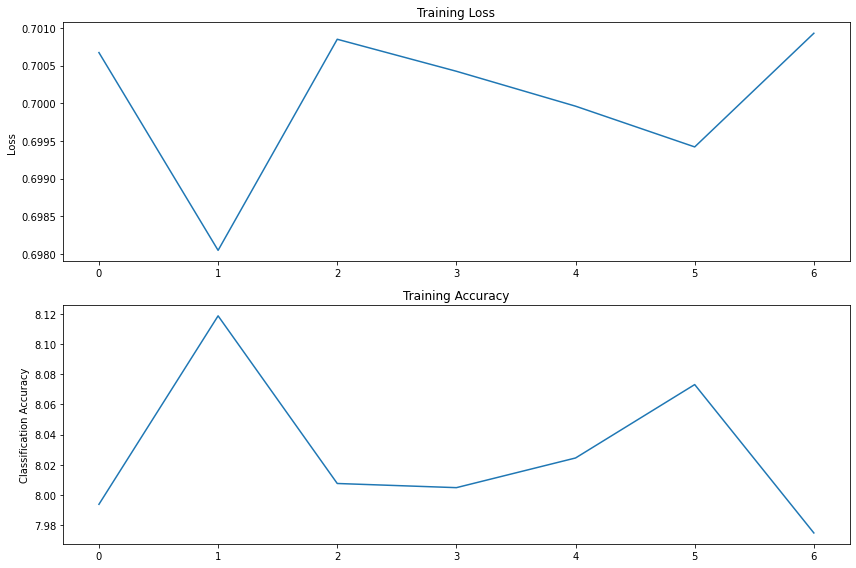

In [102]:
fig, ax = plt.subplots(2, 1, figsize=(12,8))
ax[0].plot(train_loss[:])
ax[0].set_ylabel('Loss')
ax[0].set_title('Training Loss')

ax[1].plot(train_accuracy[:])
ax[1].set_ylabel('Classification Accuracy')
ax[1].set_title('Training Accuracy')

plt.tight_layout()
plt.show()

# BERT - MLP

In [103]:
tensor_x1 = torch.Tensor(pheme_bert.values).unsqueeze(1)
tensor_y1 = torch.Tensor(pheme_y.values).unsqueeze(1)
train_dataset = TensorDataset(tensor_x1,tensor_y1)

tensor_x2 = torch.Tensor(ext_bert.values).unsqueeze(1)
tensor_y2 = torch.Tensor(ext_y.values).unsqueeze(1)
test_dataset = TensorDataset(tensor_x2,tensor_y2)

In [104]:
# Initialize WeightedRandomSampler to deal with the unbalanced dataset
counts = np.bincount(pheme_y.values)
labels_weights = 1. / counts
weights = labels_weights[pheme_y.values]
train_sampler = WeightedRandomSampler(weights, len(weights))
test_sampler = SequentialSampler(tensor_x2)

batch_size = 16

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler, num_workers=2)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

data = next(iter(train_dataloader))
print("mean: %s, std: %s" %(data[0].mean(), data[0].std()))

train_size = int(tensor_y1.size(0))
test_size = int(tensor_y2.size(0))
print(tensor_x1.shape)
print(tensor_y1.shape)
print("Train Size",train_size,"Test Size",test_size)


mean: tensor(0.0444), std: tensor(0.3107)
torch.Size([5802, 1, 768])
torch.Size([5802, 1])
Train Size 5802 Test Size 485


In [106]:
class BERT_net(nn.Module):
    def __init__(self):
        super(BERT_net, self).__init__() # 1*20
        self.fc1 = nn.Linear(768, 50, bias=True) # 420
        self.fc2 = nn.Linear(50, 8, bias=True)
        self.fc3 = nn.Linear(8, 1)

        self.drop_3 = nn.Dropout(0.3)
        self.drop_4 = nn.Dropout(0.4)
        self.drop_2 = nn.Dropout(0.2)

    def forward(self, x):
        x = self.drop_2(F.elu(self.fc1(x)))
        x = self.drop_2(F.elu(self.fc2(x)))
        x = self.fc3(x)
        return x

In [107]:
model_bert = BERT_net()
import torch.optim as optim

criterion = nn.BCEWithLogitsLoss()
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(model_bert.parameters(), lr=1e-5, weight_decay=1e-6)
scheduler = lr_scheduler.ExponentialLR(optimizer, gamma= 0.99)  
train_loss = []
train_accuracy = []

PATH = "./Model/state_dict_bert_model.pt"

In [108]:
train_accuracy, train_loss = train(model=model_bert, num_epochs=2, criterion=criterion, optimizer=optimizer, train_loader=train_dataloader, test_loader=test_dataloader, PATH=PATH)

Epoch 0/39	Train) Acc: 65.3875, Loss: 0.6945
		Validation) Acc: 24.9918 Loss:0.7690
		Saving the best model w/ loss 0.6945
		Saving the best model w/ loss 0.6889
Epoch 2/39	Train) Acc: 63.7990, Loss: 0.6798
		Validation) Acc: 24.9918 Loss:0.7542
		Saving the best model w/ loss 0.6798
		Saving the best model w/ loss 0.6755
Epoch 4/39	Train) Acc: 63.1079, Loss: 0.6728
		Validation) Acc: 24.9918 Loss:0.7493
		Saving the best model w/ loss 0.6728
		Saving the best model w/ loss 0.6708
Epoch 6/39	Train) Acc: 62.9242, Loss: 0.6709
		Validation) Acc: 24.9918 Loss:0.7474
		Saving the best model w/ loss 0.6697
Epoch 8/39	Train) Acc: 62.9604, Loss: 0.6701
		Validation) Acc: 24.9918 Loss:0.7466
Epoch 10/39	Train) Acc: 64.6305, Loss: 0.6671
		Validation) Acc: 24.9918 Loss:0.7463
		Saving the best model w/ loss 0.6671
Epoch 12/39	Train) Acc: 62.2244, Loss: 0.6712
		Validation) Acc: 24.9918 Loss:0.7461
Finishing the Model: Loss is not decreasing...


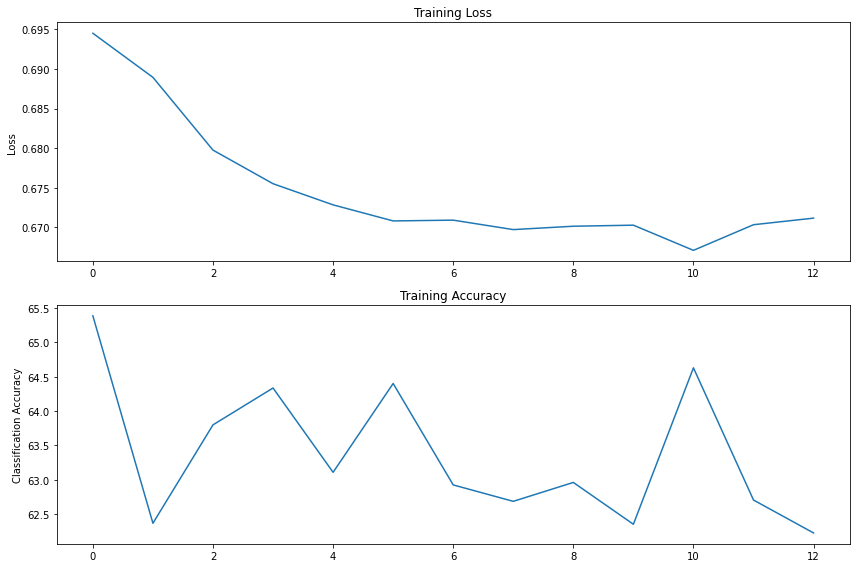

In [114]:
fig, ax = plt.subplots(2, 1, figsize=(12,8))
ax[0].plot(train_loss[:])
ax[0].set_ylabel('Loss')
ax[0].set_title('Training Loss')

ax[1].plot(train_accuracy[:])
ax[1].set_ylabel('Classification Accuracy')
ax[1].set_title('Training Accuracy')

plt.tight_layout()
plt.show()

# Sparse + W2V -> MLP

In [115]:
Train = pd.concat([pheme_w2v, pheme_sparse], axis=1)
Test = pd.concat([ext_w2v, ext_sparse], axis=1)

tensor_x1 = torch.Tensor(Train.values).unsqueeze(1)
tensor_y1 = torch.Tensor(pheme_y.values).unsqueeze(1)
train_dataset = TensorDataset(tensor_x1,tensor_y1)

tensor_x2 = torch.Tensor(Test.values).unsqueeze(1)
tensor_y2 = torch.Tensor(ext_y.values).unsqueeze(1)
test_dataset = TensorDataset(tensor_x2,tensor_y2)

In [125]:
# Initialize WeightedRandomSampler to deal with the unbalanced dataset
counts = np.bincount(pheme_y.values)
labels_weights = 1. / counts
weights = labels_weights[pheme_y.values]
train_sampler = WeightedRandomSampler(weights, len(weights))
test_sampler = SequentialSampler(tensor_x2)

batch_size=16

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler, num_workers=2)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

data = next(iter(train_dataloader))
print("mean: %s, std: %s" %(data[0].mean(), data[0].std()))

train_size = int(tensor_y1.size(0))
test_size = int(tensor_y2.size(0))
print(tensor_x1.shape)
print(tensor_y1.shape)
print("Train Size",train_size,"Test Size",test_size)


mean: tensor(74.1499), std: tensor(2274.0852)
torch.Size([5802, 1, 227])
torch.Size([5802, 1])
Train Size 5802 Test Size 485


In [126]:
class W2V_sparse_net(nn.Module):
    def __init__(self):
        super(W2V_sparse_net, self).__init__() # 1*20
        self.fc1 = nn.Linear(227, 50, bias=True) # 420
        self.fc2 = nn.Linear(50, 8, bias=True)
        self.fc3 = nn.Linear(8, 1,bias=True)

        self.drop_3 = nn.Dropout(0.3)
        self.drop_4 = nn.Dropout(0.4)
        self.drop_2 = nn.Dropout(0.2)

    def forward(self, x):
        x = self.drop_2(F.elu(self.fc1(x)))
        x = self.drop_2(F.elu(self.fc2(x)))
        x = self.fc3(x)
        return x

In [127]:
model_w2vsparse = W2V_sparse_net()
import torch.optim as optim

criterion = nn.BCEWithLogitsLoss()
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(model_w2vsparse.parameters(), lr=1e-5, weight_decay=1e-6)
scheduler = lr_scheduler.ExponentialLR(optimizer, gamma= 0.99)  
train_loss = []
train_accuracy = []

PATH = "./Model/state_dict_w2v_sparse_model.pt"

In [128]:
train_accuracy, train_loss = train(model=model_w2vsparse, num_epochs=40, criterion=criterion, optimizer=optimizer, train_loader=train_dataloader, test_loader=test_dataloader, PATH=PATH)

Epoch 0/39	Train) Acc: 8.0634, Loss: 47.2963
		Validation) Acc: 6.2825 Loss:14.2861
Epoch 2/39	Train) Acc: 8.0583, Loss: 50.2842
		Validation) Acc: 6.2825 Loss:14.2688
Epoch 4/39	Train) Acc: 8.0548, Loss: 47.4665
		Validation) Acc: 6.2825 Loss:14.2688
Finishing the Model: Loss is not decreasing...
[47.29632056593607, 45.9643080751471, 50.2841777247587, 47.41829365452829]


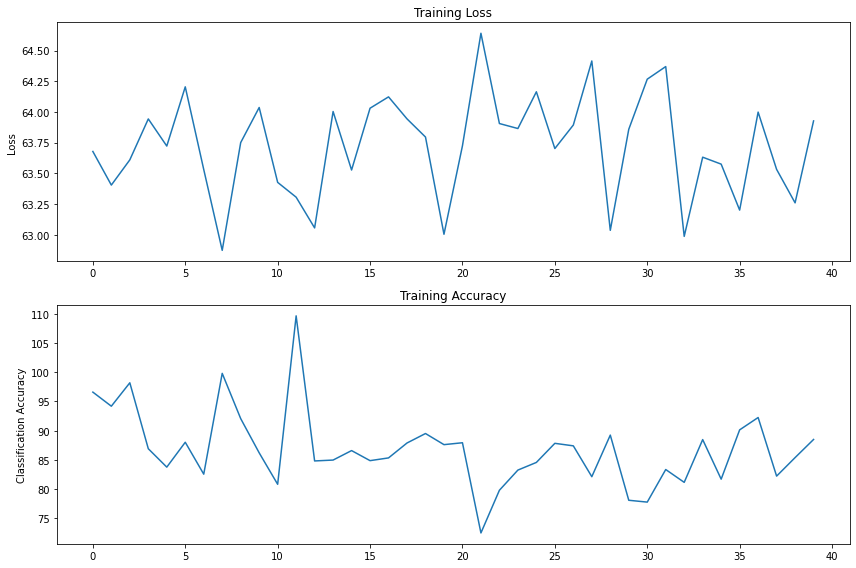

In [49]:
fig, ax = plt.subplots(2, 1, figsize=(12,8))
ax[0].plot(train_loss[:])
ax[0].set_ylabel('Loss')
ax[0].set_title('Training Loss')

ax[1].plot(train_accuracy[:])
ax[1].set_ylabel('Classification Accuracy')
ax[1].set_title('Training Accuracy')

plt.tight_layout()
plt.show()

# Sparse + BERT -> MLP

In [134]:
Train = pd.concat([pheme_bert, pheme_sparse], axis=1)
Test = pd.concat([ext_bert, ext_sparse], axis=1)

tensor_x1 = torch.Tensor(Train.values).unsqueeze(1)
tensor_y1 = torch.Tensor(pheme_y.values).unsqueeze(1)
train_dataset = TensorDataset(tensor_x1,tensor_y1)

tensor_x2 = torch.Tensor(Test.values).unsqueeze(1)
tensor_y2 = torch.Tensor(ext_y.values).unsqueeze(1)
test_dataset = TensorDataset(tensor_x2,tensor_y2)

In [135]:
# Initialize WeightedRandomSampler to deal with the unbalanced dataset
counts = np.bincount(pheme_y.values)
labels_weights = 1. / counts
weights = labels_weights[pheme_y.values]
train_sampler = WeightedRandomSampler(weights, len(weights))
test_sampler = SequentialSampler(tensor_x2)

batch_size = 16

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler, num_workers=2)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

data = next(iter(train_dataloader))
print("mean: %s, std: %s" %(data[0].mean(), data[0].std()))

train_size = int(tensor_y1.size(0))
test_size = int(tensor_y2.size(0))
print(tensor_x1.shape)
print(tensor_y1.shape)
print("Train Size",train_size,"Test Size",test_size)


mean: tensor(22.4998), std: tensor(1275.5128)
torch.Size([5802, 1, 795])
torch.Size([5802, 1])
Train Size 5802 Test Size 485


In [136]:
class BERT_sparse_net(nn.Module):
    def __init__(self):
        super(BERT_sparse_net, self).__init__() # 1*20
        self.fc1 = nn.Linear(795, 64, bias=True) # 420
        self.fc2 = nn.Linear(64, 8)
        self.fc3 = nn.Linear(8, 1)

        self.drop_3 = nn.Dropout(0.3)
        self.drop_4 = nn.Dropout(0.4)
        self.drop_2 = nn.Dropout(0.2)

    def forward(self, x):
        x = self.drop_2(F.elu(self.fc1(x)))
        x = self.drop_2(F.elu(self.fc2(x)))
        x = self.fc3(x)
        return x

In [137]:
model_bertsparse = BERT_sparse_net()

criterion = nn.BCEWithLogitsLoss()
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(model_bertsparse.parameters(), lr=1e-5, weight_decay=1e-6)
scheduler = lr_scheduler.ExponentialLR(optimizer, gamma= 0.99)  
train_loss = []
train_accuracy = []

PATH = "./Model/state_dict_bert_sparse_model.pt"

In [138]:
train_accuracy, train_loss = train(model=model_bertsparse, num_epochs=40, criterion=criterion, optimizer=optimizer, train_loader=train_dataloader, test_loader=test_dataloader, PATH=PATH)

Epoch 0/39	Train) Acc: 64.5688, Loss: 32.4294
		Validation) Acc: 97.3856 Loss:2.6970
Epoch 2/39	Train) Acc: 63.4357, Loss: 29.5844
		Validation) Acc: 97.3856 Loss:2.5422
Epoch 4/39	Train) Acc: 63.4050, Loss: 25.9870
		Validation) Acc: 97.3856 Loss:2.4845
Finishing the Model: Loss is not decreasing...
[32.429383845626795, 28.31651789597173, 29.584362176318532, 26.536607730803677]


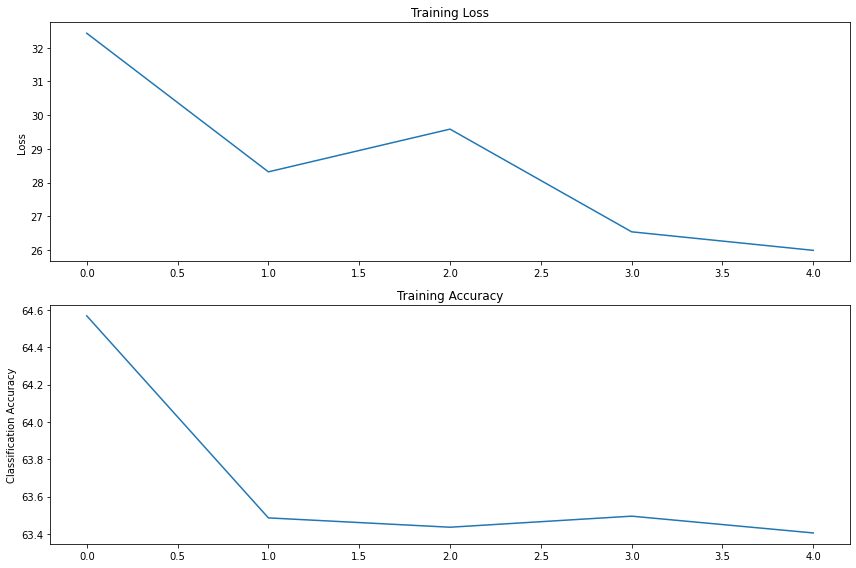

In [139]:
fig, ax = plt.subplots(2, 1, figsize=(12,8))
ax[0].plot(train_loss[:])
ax[0].set_ylabel('Loss')
ax[0].set_title('Training Loss')

ax[1].plot(train_accuracy[:])
ax[1].set_ylabel('Classification Accuracy')
ax[1].set_title('Training Accuracy')

plt.tight_layout()
plt.show()